In [ ]:
# Based on original iTEBD-example.ipynb from https://github.com/val-link/iTEBD-TEMPO.git by Valentin Link
# Adapted to do a simple simulation using OQuPy, and using a modified iTEBD-TEMPO code which uses OQuPy's BathCorrelations class by Paul Eastham


In [1]:
import oqupy as oqupy
from oqupy.iTEBD_TEMPO import iTEBD_TEMPO
from oqupy.iTEBD_TEMPO_useoqupybath import iTEBD_TEMPO_oqupy
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

In [2]:
sigma_z = oqupy.operators.sigma("z")
omega_cutoff = 3.04 
alpha = 0.126
temperature = 0.1309
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)
# uses a modified version of Link's iTEBD_TEMPO class, which will take the bath correlation defined in OQuPy
# other parameters remain as in the original, i.e. eigenvalues of the coupling operator, timestep, cut-off.
Delta=0.1
MyiTEBD_TEMPO_oqupy = iTEBD_TEMPO_oqupy(np.diagonal(sigma_z/2), Delta, correlations, 100)
MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7) 


building influence functional:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\preas\AppData\Local\Temp\ipykernel_13032\1407429750.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7)
building influence functional: 100%|██████████| 100/100 [00:00<00:00, 323.06it/s]

rank  83


In [9]:
%timeit 
# time evolution using iTEBD
H_S=0.0*oqupy.operators.sigma('z') # free Hamiltonian
Rho_0=oqupy.operators.spin_dm('x+')
N=200
Rho_t = MyiTEBD_TEMPO_oqupy.evolve(H_S, Rho_0, N)

time evolution running: 100%|██████████| 200/200 [00:00<00:00, 1080.97it/s]


In [15]:
# let's do it using OQuPy
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
tempo_parameters = oqupy.TempoParameters(dt=Delta, epsrel=10**(-7),dkmax=100)

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0.0,
                                        end_time=Delta*N,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  200 of  200 [########################################] 00:01:04
Elapsed time: 64.6s


In [ ]:
def hamiltonian_t(t):
    return 0.0 * sigma_z

system = oqupy.TimeDependentSystem(hamiltonian_t)
dynamics = oqupy.compute_dynamics(
       process_tensor=process_tensor,        
       system=system,
       initial_state=Rho_0,
       start_time=0.0)
t, s_x = dynamics.expectations(sigma_x, real=True)
_, s_y = dynamics.expectations(sigma_y, real=True)
_, s_z = dynamics.expectations(sigma_z, real=True)


--> Compute dynamics:
100.0%  200 of  200 [########################################] 00:00:05
Elapsed time: 5.0s


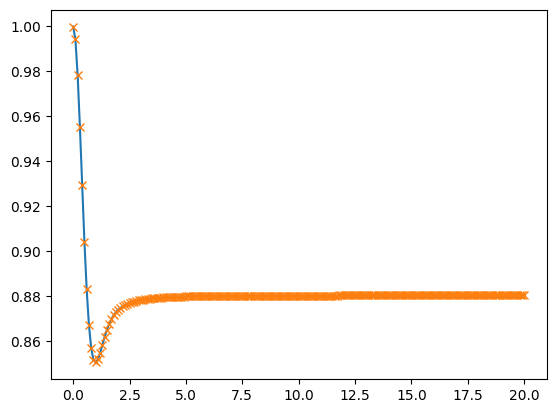

In [ ]:
T_eval = np.linspace(0, N * Delta, N + 1)
j=0.5
plt.plot(T_eval,np.einsum('ij,tji->t', qt.operators.jmat(j,'x').full(), Rho_t).real/ j)
plt.plot(t,s_x,'x')

In [1]:
import oqupy as oqupy
from oqupy.iTEBD_TEMPO import iTEBD_TEMPO
from oqupy.iTEBD_TEMPO_useoqupybath import iTEBD_TEMPO_oqupy
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

In [3]:
sigma_z = oqupy.operators.sigma("z")
omega_cutoff = 3.04 
alpha = 0.126
temperature = 0.1309
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)
# uses a modified version of Link's iTEBD_TEMPO class, which will take the bath correlation defined in OQuPy
# other parameters remain as in the original, i.e. eigenvalues of the coupling operator, timestep, cut-off.
Delta=0.1
MyiTEBD_TEMPO_oqupy = iTEBD_TEMPO_oqupy(np.diagonal(sigma_z/2), Delta, correlations, 100)
MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7) 


building influence functional:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\preas\AppData\Local\Temp\ipykernel_13032\1407429750.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  MyiTEBD_TEMPO_oqupy.compute_f(rank=100, rtol=1e-7)
building influence functional: 100%|██████████| 100/100 [00:00<00:00, 344.95it/s]

rank  83


In [4]:
from oqupy.process_tensor import TTInvariantProcessTensor

In [5]:
pt=TTInvariantProcessTensor(MyiTEBD_TEMPO_oqupy)

In [5]:
pt.get_mpo_tensor(0).shape

(1, 83, 4, 4)

In [6]:
pt.get_mpo_tensor(1).shape

(83, 83, 4, 4)

In [6]:
# let's do it using OQuPy
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
tempo_parameters = oqupy.TempoParameters(dt=Delta, epsrel=10**(-7),dkmax=100)

H_S=0.0*oqupy.operators.sigma('z') # free Hamiltonian
Rho_0=oqupy.operators.spin_dm('x+')

def hamiltonian_t(t):
    return 0.0 * sigma_z

system = oqupy.TimeDependentSystem(hamiltonian_t)

dynamics = oqupy.compute_dynamics(
       process_tensor=pt,        
       system=system,
       initial_state=Rho_0,
       start_time=0.0,
       num_steps=200)

t, s_x = dynamics.expectations(sigma_x, real=True)
_, s_y = dynamics.expectations(sigma_y, real=True)
_, s_z = dynamics.expectations(sigma_z, real=True)


--> Compute dynamics:
100.0%  200 of  200 [########################################] 00:00:02
Elapsed time: 2.9s


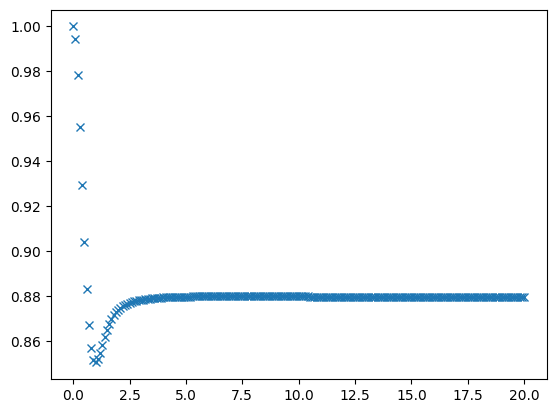

In [7]:
plt.plot(t,s_x,'x')

In [32]:
detuning = lambda t: 0.0 * t
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))

def hamiltonian_t(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 1)/2.0 * sigma_y

system = oqupy.TimeDependentSystem(hamiltonian_t)


In [33]:
Rho_0=oqupy.operators.spin_dm('z-')
dynamics = oqupy.compute_dynamics(
       process_tensor=pt,        
       system=system,
       initial_state=Rho_0,
       start_time=-5.0,
       num_steps=200)

t, s_x = dynamics.expectations(sigma_x, real=True)
_, s_y = dynamics.expectations(sigma_y, real=True)
_, s_z = dynamics.expectations(sigma_z, real=True)


--> Compute dynamics:
100.0%  200 of  200 [########################################] 00:00:03
Elapsed time: 3.4s


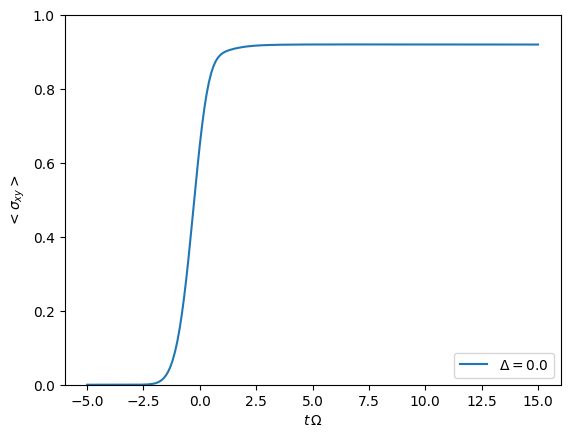

In [34]:
t, s_x = dynamics.expectations(sigma_x, real=True)
t, s_y = dynamics.expectations(sigma_y, real=True)
s_xy = np.sqrt(s_x**2 + s_y**2)
plt.plot(t, s_xy, label=r'$\Delta = 0.0$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<\sigma_{xy}>$')
plt.ylim((0.0,1.0))
plt.legend(loc=4)